In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cpu_load_df

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


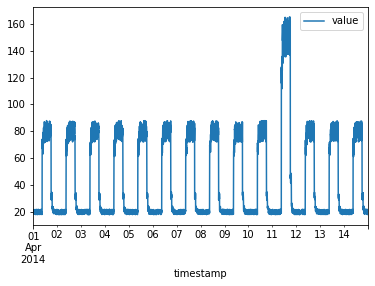

In [ ]:
cpu_load_df.plot()

정상 데이터만 넣어서 AE에 학습시키고, 비정상데이터를 넣어서? -> for what?

## 1. 정상 데이터를 구할 수 있는 경우
  1.1 말그대로 정상 샘플만 있는거
  
  1.2 이상치가 포함된 데이터에서 알고 있던 이상치 (Known Anomaly)를 제거

In [ ]:
cpu_load_normal_df = pd.read_csv(
    "/content/drive/MyDrive/시계열_교안/5주차/cpu_load_normal.csv",
    parse_dates=True, # 팬더가 자동으로 날짜를 인식 -> parse_data = True or parse_dates=['column name']이렇게 설정
    index_col='timestamp'
    )

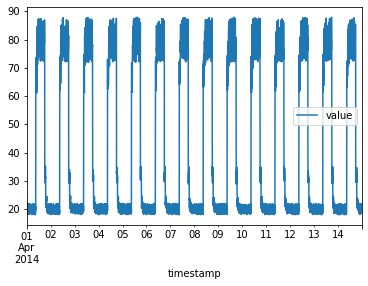

In [ ]:
cpu_load_normal_df.plot()

## 데이터 전처리

이상치값이 있는 데이터 사용

In [ ]:
training_mean = cpu_load_df.mean()
training_std = cpu_load_df.std()
df_training_value = (cpu_load_df - training_mean) / training_std # z-score 정규화

이상치가 없는 데이터(cpu_load_normal_df)를 이용

In [ ]:
training_mean = cpu_load_normal_df.mean()
training_std = cpu_load_normal_df.std()
df_training_value = (cpu_load_normal_df - training_mean) / training_std # z-score 정규화

z_score normalizaion : https://mole-starseeker.tistory.com/31

## Blocked CV 형식으로 데이터 분할

In [ ]:
# Blocked Crossvalidation
TIME_STEPS = 288 # 1440분 => 하루

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# AutoEncoder, x=y
x_train = create_sequences(df_training_value.values)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


In [ ]:
df_training_value.shape

(4032, 1)

In [ ]:
x_train.shape # (배치,데이터,?)

(3744, 288, 1)

In [ ]:
# CNN 기반 모델 -> why use CNN -> 구간 반복이 존재한다. 선/후 관계가 중요한게 아니여서 -> 그래서 LSTM을 안쓰고 CNN을 사용한다
model = keras.Sequential(
    [                         # 288,                1
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])), # 288, 1
        # 요약한 정보를 32차원으로 바꾸고, 7개의 window를 보고, 2개 중에서 pooling을 하겠다.
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 144, 32
        ),
        layers.Dropout(rate=0.2),
        # 요약한 정보를 16차원으로 바꾸고, 7개의 window를 보고, 2개 중에서 pooling을 하겠다
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 72, 16 -> CNN 코드를 쓸 때 이렇게 적어주는게 좋을거 같다
        ),
        layers.Conv1D(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 36, 8
        ),
        layers.Conv1D(
              filters=4, kernel_size=7, padding="same", strides=2, activation="relu" # 18차원, 4 <= z vector / Encoder 끝.
          ),
        # Decoder 시작 -> up sampling
        layers.Conv1DTranspose(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 36, 8
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 72, 16
        ),
        layers.Dropout(rate=0.2),
        # 32차원으로 7개의 윈도우를 봐서, stride=2이므로, 시계열이 2배로 확장.
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 144, 32
        ),
          layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 288, 32
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"), # 288, 1, 원본 시계열 - 입력과 똑같은 shape
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_6 (Conv1D)           (None, 36, 8)             904       
                                                                 
 conv1d_7 (Conv1D)           (None, 18, 4)             228       
                                                                 
 conv1d_transpose_5 (Conv1DT  (None, 36, 8)            232       
 ranspose)                                                       
                                                      

In [ ]:
history = model.fit(
    x_train,
    x_train, # 원래 y값 자리지만, AE에 대한 구조를 이해하면 x_train이 맞는 값으로 들어온거다
    epochs=50,
    batch_size=128
)

Epoch 1/50
30/30 [==============================] - 4s 105ms/step - loss: 0.6802
Epoch 2/50
30/30 [==============================] - 3s 104ms/step - loss: 0.3822
Epoch 3/50
30/30 [==============================] - 3s 105ms/step - loss: 0.2425
Epoch 4/50
30/30 [==============================] - 3s 106ms/step - loss: 0.0943
Epoch 5/50
30/30 [==============================] - 3s 106ms/step - loss: 0.0607
Epoch 6/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0523
Epoch 7/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0469
Epoch 8/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0433
Epoch 9/50
30/30 [==============================] - 3s 109ms/step - loss: 0.0403
Epoch 10/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0372
Epoch 11/50
30/30 [==============================] - 3s 104ms/step - loss: 0.0351
Epoch 12/50
30/30 [==============================] - 3s 105ms/step - loss: 0.0329
Epoch 13/50
30/30 [======

In [ ]:
x_train_pred = model.predict(x_train)

In [ ]:
x_train_pred.shape

(3744, 288, 1)

## 학습 데이터를 그대로 복원  => 복원된 데이터와 학습 데이터를 비교

## 이상치 포함

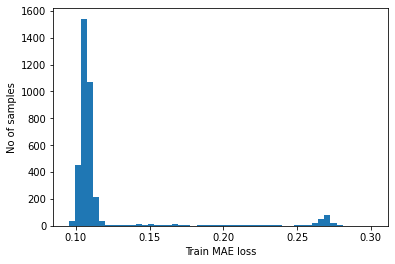

Reconstruction error threshold:  0.36180702939322795


In [ ]:
x_train_pred = model.predict(x_train)
                          # 예측값 각각에 대한 mean absoulte err
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1) # loss를 구한다.

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show() # loss 분포를 구한다 - 시각적 표현

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss) * 1 # 학습 데이터의 최대 에러의 95% 수준보다 넘어가는건 이상치다.
threshold = np.max(train_mae_loss) * 1.2 # 0.9로 값을 바꾸면,threshold값이 떨어진다 => 이유는 무엇일까? -> 근데 오류가 뜬다. why? threshold값이 너무 작아서? 그래서 threshold = 0.15로 바꾸니까 코드가 됨 ..
print("Reconstruction error threshold: ", threshold)

0.25~0.30 그래프에서 값이 튀어나와있는 것을 보면 이상치가 포함되어있는 데이터이기 때문에 포함이 된 것으로 판단할 수 있다.

-> 그래프가 살짝 좌측에 치우친 보아뱀?형태 그래프로 나타낸다면, 우측부분에서 이상치가 발견된 것을 알 수 있다.

## 이상치 포함 X

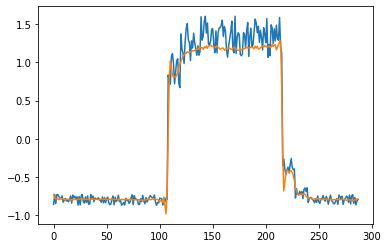

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
df_test_value = (cpu_load_df - training_mean) / training_std

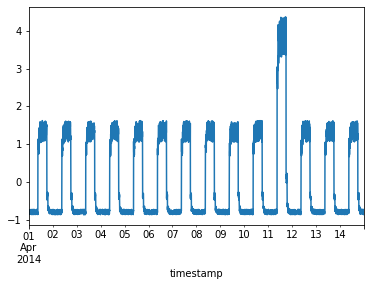

Test input shape:  (3744, 288, 1)


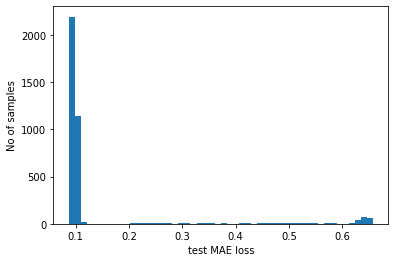

Number of anomaly samples:  391
Indices of anomaly samples:  (array([2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714,
       2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725,
       2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736,
       2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747,
       2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758,
       2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769,
       2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780,
       2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791,
       2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802,
       2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813,
       2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824,
       2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835,
       2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2

In [ ]:
df_test_value = (cpu_load_df - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
anomalous_data_indices # 데이터가 잘 쌓였는지 확인하는 코드이다!

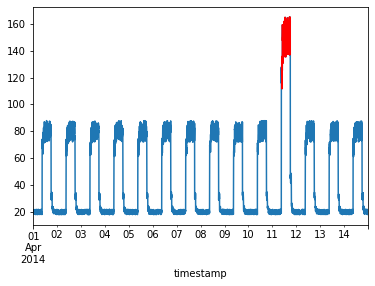

In [ ]:
df_subset = cpu_load_df.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
cpu_load_df.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()